In [2]:
import numpy as np
import pandas as pd

import os
import urllib.request
import sys

from sklearn.model_selection import train_test_split

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as f
import torch.optim as optim

import torchvision
from torchvision.transforms import v2
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim.lr_scheduler as lr_scheduler

import random
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [5]:
df = pd.read_csv('/content/drive/MyDrive/multimodal_only_samples/multimodal_train.tsv', sep='\t')

In [6]:
df.drop(['2_way_label', '3_way_label', 'title'], axis = 1, inplace =True)

In [7]:
df, df_backup = train_test_split(
    df,
    test_size=0.95,
    shuffle=True,
    stratify=df["6_way_label"]
)

In [8]:
df.reset_index(drop=True, inplace=True)
df

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,upvote_ratio,6_way_label
0,mrcroghan,coconut carolers,1.557610e+09,i.redd.it,True,bnh8k1,https://preview.redd.it/rng08b6ngnx21.jpg?widt...,NaN,0.0,3,pareidolia,1.00,2
1,michaelconfoy,psychologists urge people with low selfesteem ...,1.438871e+09,newyorker.com,True,3g09k8,https://external-preview.redd.it/XU9UgdmL-sU-A...,NaN,0.0,8,satire,1.00,1
2,galileofan,dont act like you didnt know this was coming,1.357029e+09,NaN,True,c7p5bdi,http://i.imgur.com/ce8NJ.jpg,15rjrk,NaN,137,psbattle_artwork,NaN,4
3,txpxy,someone built a shower in front of this shower,1.563107e+09,i.redd.it,True,cd2eqi,https://preview.redd.it/q8m0ywtth9a31.jpg?widt...,NaN,3.0,6,mildlyinteresting,0.88,0
4,Yare_Daze,man machine bigger than us,1.523184e+09,i.redd.it,True,8ap79z,https://preview.redd.it/ce3r9avpynq01.png?widt...,NaN,48.0,3673,fakealbumcovers,0.98,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28195,mandal0re,kissed by fire,1.503282e+09,NaN,True,dlwo8vf,http://i.imgur.com/fKKGpHF.jpg,6uz5c2,NaN,1687,psbattle_artwork,NaN,4
28196,titanicnarwhal,the sorting cone,1.493542e+09,i.redd.it,True,68ekof,https://preview.redd.it/ymlsawytmnuy.jpg?width...,NaN,20.0,2345,pareidolia,0.96,2
28197,ediculous,birdseye view of hydrated vs dehydrated topsoil,1.487282e+09,gfycat.com,True,5ui5du,https://external-preview.redd.it/Y8pyc6X5vScXM...,NaN,0.0,15,misleadingthumbnails,0.83,2
28198,danielmarkwright,angry stripper,1.527843e+09,NaN,True,dzxickt,https://i.imgur.com/xI62rae.jpg,8nows2,NaN,1201,psbattle_artwork,NaN,4


In [96]:
print(df['clean_title'].isnull().sum())
print(df['id'].isnull().sum())
print(df['hasImage'].isnull().sum())
print(df['hasImage'].value_counts())

0
0
0
hasImage
True    2436
Name: count, dtype: int64


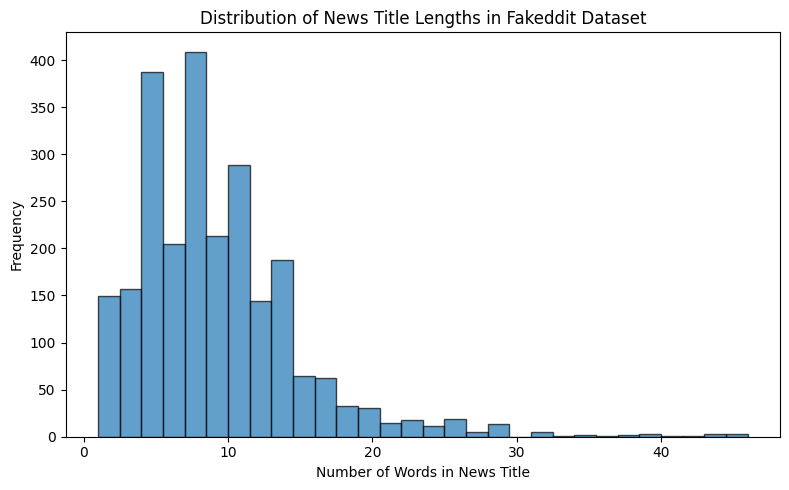

In [92]:
import matplotlib.pyplot as plt

# Calculate text lengths
df["title_length"] = df["clean_title"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
plt.hist(df["title_length"], bins=30, edgecolor="black", alpha=0.7)

plt.xlabel("Number of Words in News Title")
plt.ylabel("Frequency")
plt.title("Distribution of News Title Lengths in Fakeddit Dataset")

plt.tight_layout()
plt.show()


/tmp/ipython-input-3378143293.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


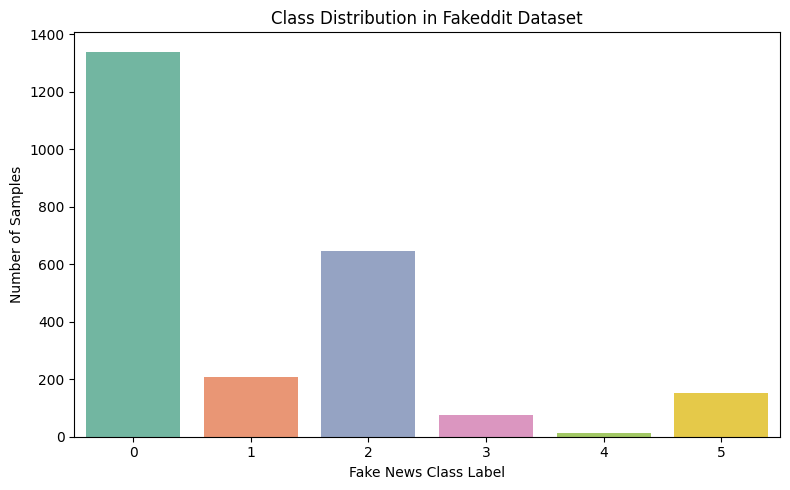

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(
    x="6_way_label",
    data=df,
    palette="Set2"
)

plt.xlabel("Fake News Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Fakeddit Dataset")

plt.tight_layout()
plt.show()


Based on the class distribution graph, i will say that the classes are not represented equally in the dataset.

Due to this, I applied balanced class weights later on in my loss function

In [23]:
import os
import numpy as np
from urllib import request
import time

df = df.replace(np.nan, '', regex=True)
df.fillna('', inplace=True)

SAVE_DIR = "/content/drive/MyDrive/multimodal_only_images"
os.makedirs(SAVE_DIR, exist_ok=True)

MAX_IMAGES = 3000
downloaded = 0

start_time = time.time()

for index, row in df.iterrows():
    if downloaded >= MAX_IMAGES:
        break

    if row.get("hasImage") == True and row.get("image_url") not in ["", "nan"]:
        image_url = row["image_url"]
        image_id = str(row["id"])
        path = os.path.join(SAVE_DIR, image_id + ".jpg")

        try:
            request.urlretrieve(image_url, path)
            downloaded += 1

            if downloaded % 50 == 0:
                print(f"Downloaded {downloaded} images")

        except:
            continue

    if time.time() - start_time > 3000:
        print("Time limit reached (5 minutes)")
        break

print(f"Finished downloading {downloaded} images")


Downloaded 50 images
Downloaded 100 images
Downloaded 150 images
Downloaded 200 images
Downloaded 250 images
Downloaded 300 images
Downloaded 350 images
Downloaded 400 images
Downloaded 450 images
Downloaded 500 images
Downloaded 550 images
Downloaded 600 images
Downloaded 650 images
Downloaded 700 images
Downloaded 750 images
Downloaded 800 images
Downloaded 850 images
Downloaded 900 images
Downloaded 950 images
Downloaded 1000 images
Downloaded 1050 images
Downloaded 1100 images
Downloaded 1150 images
Downloaded 1200 images
Downloaded 1250 images
Downloaded 1300 images
Downloaded 1350 images
Downloaded 1400 images
Downloaded 1450 images
Downloaded 1500 images
Downloaded 1550 images
Downloaded 1600 images
Downloaded 1650 images
Downloaded 1700 images
Downloaded 1750 images
Downloaded 1800 images
Downloaded 1850 images
Downloaded 1900 images
Downloaded 1950 images
Downloaded 2000 images
Downloaded 2050 images
Downloaded 2100 images
Downloaded 2150 images
Downloaded 2200 images
Download

Image shape (H, W, C): (426, 320, 3)


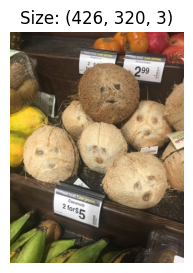

Image shape (H, W, C): (180, 320, 3)


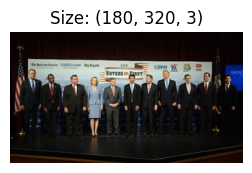

Image shape (H, W, C): (426, 320, 3)


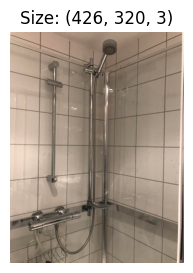

Image shape (H, W, C): (320, 320, 3)


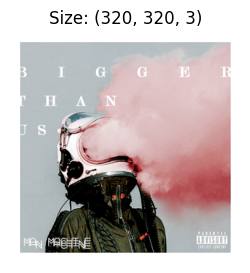

Image shape (H, W, C): (224, 320, 3)


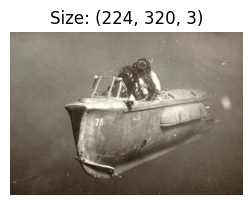

In [27]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

IMAGE_DIR = "/content/drive/MyDrive/multimodal_only_images"

shown = 0

for _, row in df.iterrows():
    image_path = os.path.join(IMAGE_DIR, str(row["id"]) + ".jpg")

    if os.path.exists(image_path):
        img = Image.open(image_path).convert("RGB")
        img_np = np.array(img)

        print("Image shape (H, W, C):", img_np.shape)

        plt.figure(figsize=(3,3))
        plt.imshow(img_np)
        plt.title(f"Size: {img_np.shape}")
        plt.axis("off")
        plt.show()

        shown += 1
        if shown == 5:
            break


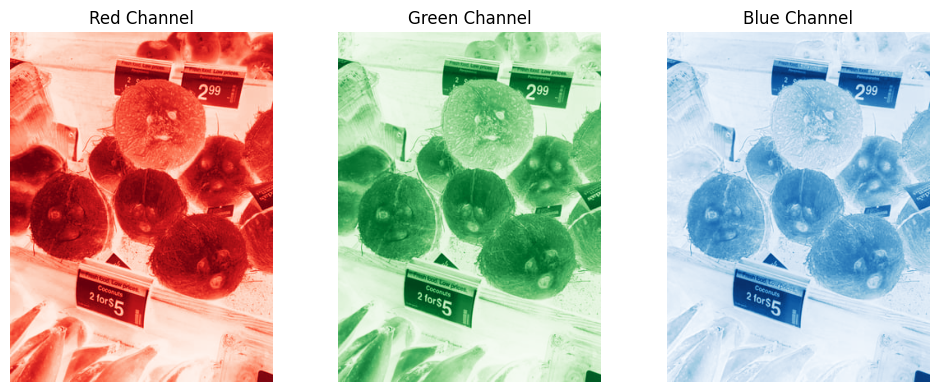

In [29]:
import os
import matplotlib.pyplot as plt
from PIL import Image

IMAGE_DIR = "/content/drive/MyDrive/multimodal_only_images"

image_id = str(df["id"].iloc[0])
image_path = os.path.join(IMAGE_DIR, image_id + ".jpg")

if os.path.exists(image_path):
    image = Image.open(image_path).convert("RGB")

    r, g, b = image.split()

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(r, cmap="Reds")
    plt.title("Red Channel")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(g, cmap="Greens")
    plt.title("Green Channel")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(b, cmap="Blues")
    plt.title("Blue Channel")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("Image file not found:", image_path)


In [32]:
import os
from PIL import Image

def validate_images(df, image_dir):
    corrupted_ids = []

    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, str(row["id"]) + ".jpg")

        if not os.path.exists(image_path):
            corrupted_ids.append(row["id"])
            continue

        try:
            with Image.open(image_path) as img:
                img.verify()
        except Exception as e:
            print(f"Corrupted image: {image_path} | Error: {e}")
            corrupted_ids.append(row["id"])

    return corrupted_ids


IMAGE_DIR = "/content/drive/MyDrive/multimodal_only_images"

print("Clean dataframe size:", df.shape)


Clean dataframe size: (2436, 13)


In [34]:
import os
from PIL import Image
from torchvision.transforms import v2

IMAGE_DIR = "/content/drive/MyDrive/multimodal_only_images"
resize_transform = v2.Resize((256, 256))

resized = 0
skipped = 0

for _, row in df.iterrows():
    image_path = os.path.join(IMAGE_DIR, str(row["id"]) + ".jpg")

    if not os.path.exists(image_path):
        skipped += 1
        continue

    try:
        image = Image.open(image_path).convert("RGB")
        resized_image = resize_transform(image)
        resized_image.save(image_path)
        resized += 1
    except Exception as e:
        skipped += 1
        continue

print(f"Resized images: {resized}")
print(f"Skipped images (missing/corrupt): {skipped}")


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Resized images: 2436
Skipped images (missing/corrupt): 0


Image shape: (256, 256, 3)


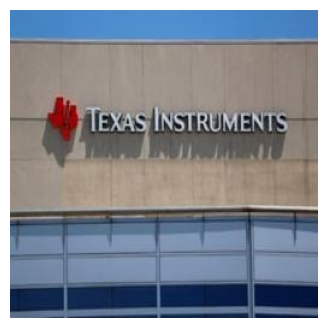

Image shape: (256, 256, 3)


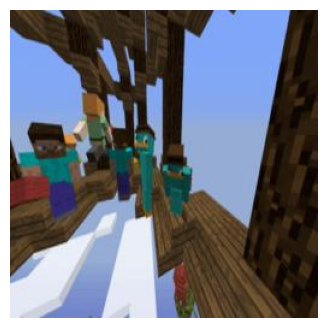

Image shape: (256, 256, 3)


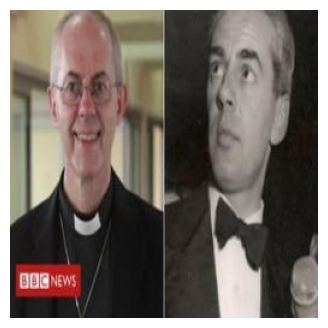

Image shape: (256, 256, 3)


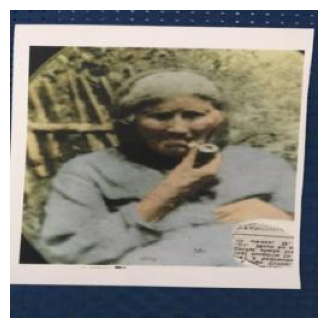

Image shape: (256, 256, 3)


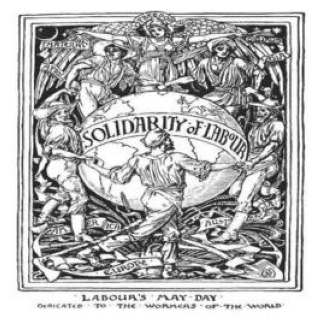

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

IMAGE_DIR = "/content/drive/MyDrive/multimodal_only_images"

shown = 0
i = 0

while shown < 5 and i < len(df):
    image_path = os.path.join(IMAGE_DIR, str(df["id"].iloc[i]) + ".jpg")

    if os.path.exists(image_path):
        im = np.array(Image.open(image_path).convert("RGB"))

        print("Image shape:", im.shape)

        plt.figure(figsize=(4,4))
        plt.imshow(im)
        plt.axis("off")
        plt.show()

        shown += 1

    i += 1


In [41]:
! pip install bert-serving-server
! pip install bert-serving-client
! pip install torch transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 3.1 MB/s eta 0:00:00
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=7d1ad0dd0c4f5010f8592ffa6b037c32cac2a4e85c38fad7affd3297464a1f7a
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built GPUtil
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 3.2 MB/s eta 0:00:00


In [42]:
import torch
from transformers import BertModel, BertTokenizer

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name, output_hidden_states = True)

bert_model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [43]:
def get_bert_embedding(text):
    inputs = tokenizer.encode_plus(text, add_special_tokens = True, return_tensors='pt', max_length=80, truncation=True, padding='max_length')

    return inputs['input_ids'].squeeze(0), inputs['attention_mask'].squeeze(0)

text = "This is an example Reddit submission title."
input_ids, attention_mask = get_bert_embedding(text)
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([80])
torch.Size([80])


In [44]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df["6_way_label"])
df_test, df_val = train_test_split(df_test, test_size=0.5, stratify=df_test["6_way_label"])

In [53]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2
from PIL import Image

class FakedditDataset(Dataset):
    def __init__(self, df, text_field="clean_title", label_field="6_way_label", image_id="id"):
        self.df = df.reset_index(drop=True)
        self.text_field = text_field
        self.label_field = label_field
        self.image_id = image_id

        self.image_dir = "/content/drive/MyDrive/multimodal_only_images"

        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

        self.transform_func = v2.Compose([
            v2.Resize((256, 256)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(self.mean, self.std)
        ])

        self.fallback_image = Image.new("RGB", (256, 256), (0, 0, 0))

    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = torch.tensor(self.df.at[index, self.label_field], dtype=torch.long)

        img_name = str(self.df.at[index, self.image_id]) + ".jpg"
        img_path = os.path.join(self.image_dir, img_name)

        if os.path.exists(img_path):
            image = Image.open(img_path).convert("RGB")
        else:
            image = self.fallback_image

        img = self.transform_func(image)

        input_ids, attention_mask = get_bert_embedding(text)

        return input_ids, attention_mask, label, img

    def __len__(self):
        return len(self.df)


In [54]:
train_dataset = FakedditDataset(df_train)
val_dataset = FakedditDataset(df_val)
test_dataset = FakedditDataset(df_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [55]:
input_ids, attention_mask, label, img = next(iter(train_loader))
print(input_ids.shape, attention_mask.shape, label.shape, img.shape)


torch.Size([16, 80]) torch.Size([16, 80]) torch.Size([16]) torch.Size([16, 3, 256, 256])


In [57]:
class MultimodalClassifier(nn.Module):
    def __init__(self, num_classes=6):

        super(MultimodalClassifier, self).__init__()

        self.num_classes = num_classes

        self.image_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.image_fc = nn.Sequential(
            nn.Linear(128 * 32 * 32, num_classes),
            nn.ReLU()
        )

        self.drop = nn.Dropout(p=0.3)

        self.text_model = BertModel.from_pretrained("bert-base-uncased")
        self.fc_text = nn.Linear(in_features=self.text_model.config.hidden_size, out_features=num_classes, bias=True)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, image, text_input_ids, text_attention_mask,):

        x_img = self.image_conv(image)
        x_img = x_img.view(x_img.size(0), -1)
        x_img = self.image_fc(x_img)
        x_img = self.drop(x_img)

        x_text_last_hidden_states = self.text_model(
            input_ids = text_input_ids,
            attention_mask = text_attention_mask,
            return_dict=False
        )
        x_text_pooled_output = x_text_last_hidden_states[0][:, 0, :]
        x_text = self.fc_text(x_text_pooled_output)
        x_text = self.drop(x_text)

        x = torch.max(x_text, x_img)

        return x

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MultimodalClassifier(num_classes=6)
model= model.to(device)

In [59]:
class EarlyStopping:
    def __init__(self, patience=4, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [60]:
labels = df_train['6_way_label'].to_numpy()

In [68]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import lr_scheduler
model = model.to(device)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

num_epochs = 20

class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    early_stopping = EarlyStopping(patience=5)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for input_ids, attention_mask, label, img in train_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            img = img.to(device)

            optimizer.zero_grad()
            outputs = model(img, input_ids, attention_mask)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * img.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for input_ids, attention_mask, label, img in val_loader:
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                label = label.to(device)
                img = img.to(device)

                outputs = model(img, input_ids, attention_mask)
                loss = criterion(outputs, label)

                val_loss += loss.item() * img.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += torch.sum(preds == label)

        val_loss /= len(val_loader.dataset)
        accuracy = correct.double() / len(val_loader.dataset)

        scheduler.step(val_loss)

        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {accuracy:.4f}"
        )

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs
)


Epoch 1/20 | Train Loss: 1.7920 | Val Loss: 1.7869 | Val Acc: 0.5492
Epoch 2/20 | Train Loss: 1.7779 | Val Loss: 1.7473 | Val Acc: 0.5492
Epoch 3/20 | Train Loss: 1.7894 | Val Loss: 1.7918 | Val Acc: 0.5451
Epoch 4/20 | Train Loss: 1.7918 | Val Loss: 1.7918 | Val Acc: 0.5451
Epoch 5/20 | Train Loss: 1.7918 | Val Loss: 1.7918 | Val Acc: 0.5451
Epoch 6/20 | Train Loss: 1.7918 | Val Loss: 1.7918 | Val Acc: 0.5451
Epoch 7/20 | Train Loss: 1.7918 | Val Loss: 1.7918 | Val Acc: 0.5451
Early stopping triggered. Stopping training.


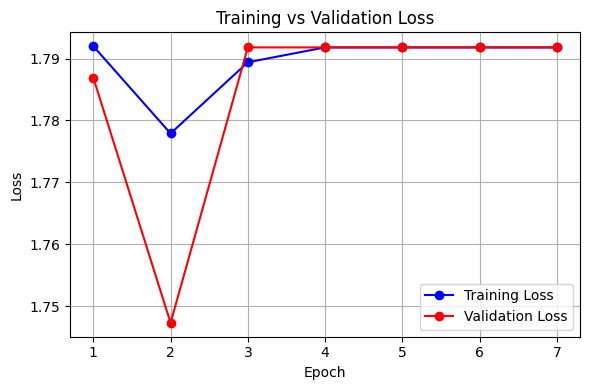

In [76]:
import matplotlib.pyplot as plt

train_losses = [
    1.7920, 1.7779, 1.7894, 1.7918, 1.7918, 1.7918, 1.7918
]

val_losses = [
    1.7869, 1.7473, 1.7918, 1.7918, 1.7918, 1.7918, 1.7918
]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, marker='o', color='blue', label='Training Loss')
plt.plot(epochs, val_losses, marker='o', color='red', label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


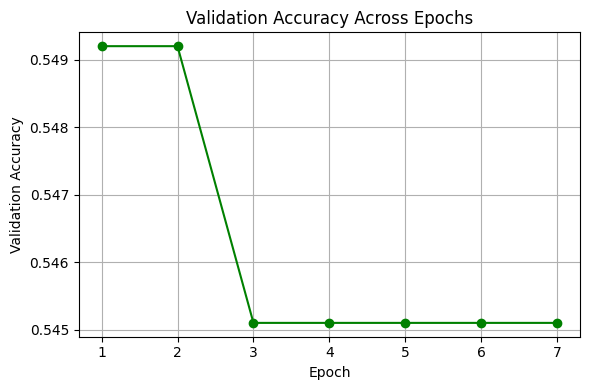

In [77]:
val_accuracy = [
    0.5492, 0.5492, 0.5451, 0.5451, 0.5451, 0.5451, 0.5451
]

plt.figure(figsize=(6,4))
plt.plot(epochs, val_accuracy, marker='o', color='green')

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Across Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()


In [78]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score
import torch.nn as nn

model = model.to(device)

def evaluate_model(model, test_loader, criterion):
    model.eval()

    correct_preds = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, label, img in test_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            img = img.to(device)

            outputs = model(img, input_ids, attention_mask)

            loss = criterion(outputs, label)
            _, preds = torch.max(outputs, dim=1)

            correct_preds += torch.sum(preds == label)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    accuracy = (correct_preds.double() / len(test_loader.dataset)).item()
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)

    print("Test Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)


evaluate_model(model, test_loader, criterion)


Test Accuracy: 0.5491803278688525
Precision: 0.30159903251814035
Recall: 0.5491803278688525


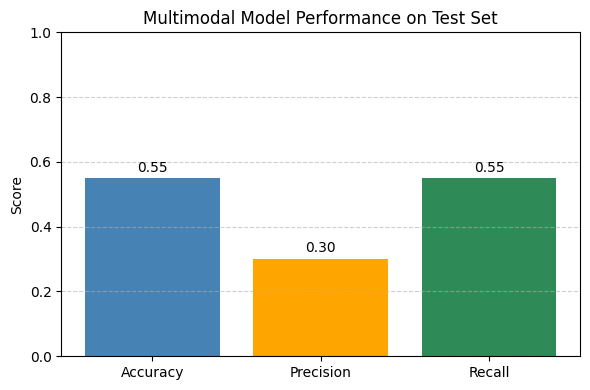

In [79]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall"]
values = [0.5491803278688525, 0.30159903251814035, 0.5491803278688525]

plt.figure(figsize=(6,4))
bars = plt.bar(metrics, values, color=["steelblue", "orange", "seagreen"])

plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Multimodal Model Performance on Test Set")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.02,
        f"{height:.2f}",
        ha="center",
        fontsize=10
    )

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [80]:
class BERTResNetClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super(BERTResNetClassifier, self).__init__()
        self.num_classes = num_classes
        # Image processing (ResNet)
        self.image_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        # Image processing (Fully Connected Layer)
        self.fc_image = nn.Linear(in_features=1000, out_features=num_classes, bias=True)
        self.drop = nn.Dropout(p=0.3)
        # Text processing (using the 768-dimensional BERT arrays)
        self.text_model = BertModel.from_pretrained("bert-base-uncased")
        # Text processing (Fully Connected Layer)
        self.fc_text = nn.Linear(in_features=self.text_model.config.hidden_size, out_features=num_classes, bias=True)
        # Fusion and classification
        self.softmax = nn.Softmax(dim=1)
    def forward(self, image, text_input_ids, text_attention_mask,):
        x_img = self.image_model(image)
        x_img = self.drop(x_img)
        x_img = self.fc_image(x_img)
        # Text branch
        x_text_last_hidden_states = self.text_model(
            input_ids = text_input_ids,
            attention_mask = text_attention_mask,
            return_dict=False
        )
        x_text_pooled_output = x_text_last_hidden_states[0][:, 0, :]
        x_text = self.drop(x_text_pooled_output)
        x_text = self.fc_text(x_text_pooled_output)
        x = torch.max(x_text, x_img)

        return x

In [82]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = BERTResNetClassifier(num_classes=6)
model= model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-6, factor=0.5, patience=1,)
num_epochs = 20

train_model(model, train_loader,val_loader, criterion, optimizer, scheduler, num_epochs)
#print("\n")
evaluate_model(model, test_loader, criterion)

Epoch 1/20 | Train Loss: 1.6781 | Val Loss: 1.4715 | Val Acc: 0.5041
Epoch 2/20 | Train Loss: 1.2265 | Val Loss: 1.2839 | Val Acc: 0.6639
Epoch 3/20 | Train Loss: 0.8338 | Val Loss: 1.2332 | Val Acc: 0.6311
Epoch 4/20 | Train Loss: 0.5435 | Val Loss: 1.3566 | Val Acc: 0.6967
Epoch 5/20 | Train Loss: 0.3489 | Val Loss: 1.4590 | Val Acc: 0.6885
Epoch 6/20 | Train Loss: 0.2418 | Val Loss: 1.5766 | Val Acc: 0.6721
Epoch 7/20 | Train Loss: 0.1935 | Val Loss: 1.5997 | Val Acc: 0.6926
Epoch 8/20 | Train Loss: 0.1570 | Val Loss: 1.7038 | Val Acc: 0.6967
Early stopping triggered. Stopping training.
Test Accuracy: 0.7254098360655739
Precision: 0.7211774598152942
Recall: 0.7254098360655737


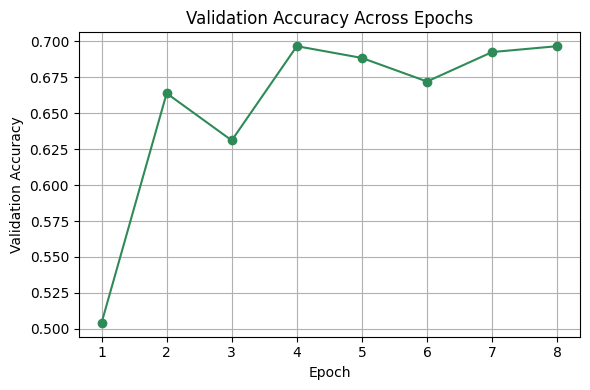

In [84]:
val_accuracy = [
    0.5041, 0.6639, 0.6311, 0.6967,
    0.6885, 0.6721, 0.6926, 0.6967
]

plt.figure(figsize=(6,4))
plt.plot(epochs, val_accuracy, marker="o", color="seagreen")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Across Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()


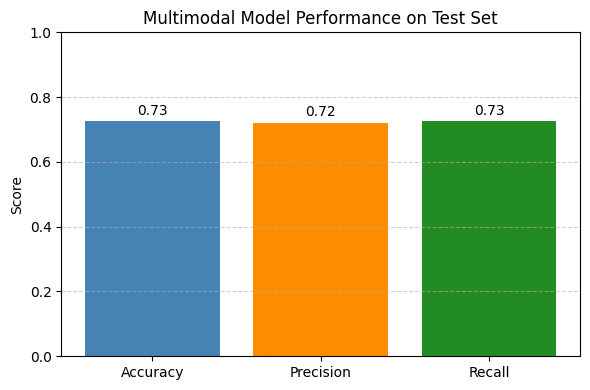

In [3]:
import matplotlib.pyplot as plt
metrics = ["Accuracy", "Precision", "Recall"]
values = [
    0.7254098360655739,
    0.7211774598152942,
    0.7254098360655737
]

colors = ["steelblue", "darkorange", "forestgreen"]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=colors)

plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Multimodal Model Performance on Test Set")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{height:.2f}",
        ha="center",
        fontsize=10
    )

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
